# Application 

<span style="color:green;">Helps identifying & Classifying ***Fake news*** on your Social Media app.
</span>  


### Importing ***Packages*** and ***dataset***

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy import displacy
from spacy import tokenizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_color = "#8d0cc0"

In [3]:
data = pd.read_csv("fake_news_data.csv")

### EDA

<span style="color:brown; font-weight:bold;">Exploratory</span>  
<span style="color:orange; font-weight:bold;">Data</span>  
<span style="color:rose; font-weight:bold;">Analysis</span>

##### Info & plots

In [4]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Article Classification (fake & factual)')

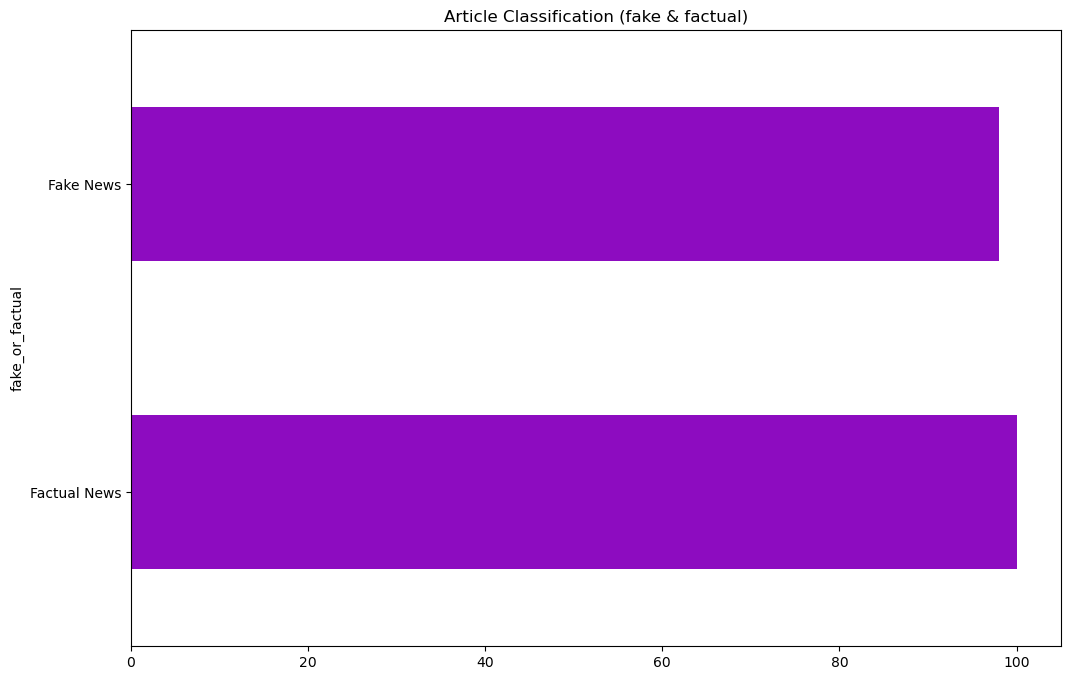

In [6]:
data['fake_or_factual'].value_counts().plot(kind='barh', color=default_plot_color)
plt.title("Article Classification (fake & factual)")

##### POS Tagging

In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [9]:
fake_spacy_docs = list(nlp.pipe(fake_news['text']))
fact_spacy_docs = list(nlp.pipe(fact_news['text']))

In [10]:
def extract_token_tags(docs: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in docs]

In [11]:
fake_tags_df = []
columns = ['token', 'ner_tag', 'pos_tag']

In [12]:
for ix, doc in enumerate(fake_spacy_docs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tags_df.append(tags)

In [13]:
fake_tags_df[0]

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN
...,...,...,...
388,.,,PUNCT
389,Via,,NOUN
390,:,,PUNCT
391,Breitbart,ORG,PROPN


In [14]:
fake_tags_df = pd.concat(fake_tags_df)

In [15]:
fake_tags_df[:2]

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB


In [16]:
fact_tags_df = []

for ix, doc in enumerate(fact_spacy_docs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tags_df.append(tags)

In [17]:
fact_tags_df[0]

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT
...,...,...,...
113,of,,ADP
114,its,,PRON
115,operational,,ADJ
116,plans,,NOUN


In [18]:
fact_tags_df = pd.concat(fact_tags_df)

In [19]:
fact_tags_df.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [20]:
# Token frequency counts

fake_pos_counts = fake_tags_df.groupby(['token', 'pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
fake_pos_counts.head(7)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795


In [21]:
fact_pos_counts = fact_tags_df.groupby(['token', 'pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
fact_pos_counts.head(7)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672


In [22]:
fake_pos_counts.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2597
VERB     1814
PROPN    1657
ADJ       876
ADV       412
NUM       221
PRON       99
ADP        88
AUX        58
SCONJ      54
DET        42
INTJ       27
PUNCT      27
X          19
CCONJ      19
PART       10
SYM         6
SPACE       3
Name: token, dtype: int64

In [23]:
fact_pos_counts.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2182
VERB     1535
PROPN    1387
ADJ       753
ADV       271
NUM       203
PRON       81
ADP        70
AUX        44
SCONJ      39
DET        35
PUNCT      19
X          12
SPACE      11
CCONJ       9
INTJ        8
PART        8
SYM         5
Name: token, dtype: int64

In [24]:
fake_pos_counts[fake_pos_counts.pos_tag == "NOUN"]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
...,...,...,...
3783,diagnosis,NOUN,1
3780,devil,NOUN,1
3779,devices,NOUN,1
3777,developments,NOUN,1


In [25]:
fact_pos_counts[fact_pos_counts.pos_tag == "NOUN"]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
...,...,...,...
4202,journalist,NOUN,1
4205,journey,NOUN,1
4153,investigator,NOUN,1
1768,U.S.-Mexico,NOUN,1


##### NER

In [26]:
fake_top_entitites = fake_tags_df[fake_tags_df['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by="counts", ascending=False)
fact_top_entitites = fact_tags_df[fact_tags_df['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by="counts", ascending=False)

In [27]:
ner_color_palette = {
    'ORG' : sns.color_palette('Set2').as_hex()[0],
    'GPE' : sns.color_palette('Set2').as_hex()[1],
    'NORP' : sns.color_palette('Set2').as_hex()[2],
    'PERSON' : sns.color_palette('Set2').as_hex()[3],
    'DATE' : sns.color_palette('Set2').as_hex()[4],
    'CARDINAL' : sns.color_palette('Set2').as_hex()[5],
    'PERCENT' : sns.color_palette('Set2').as_hex()[6],
}

[Text(0.5, 1.0, 'Common Named Entities in Fake News')]

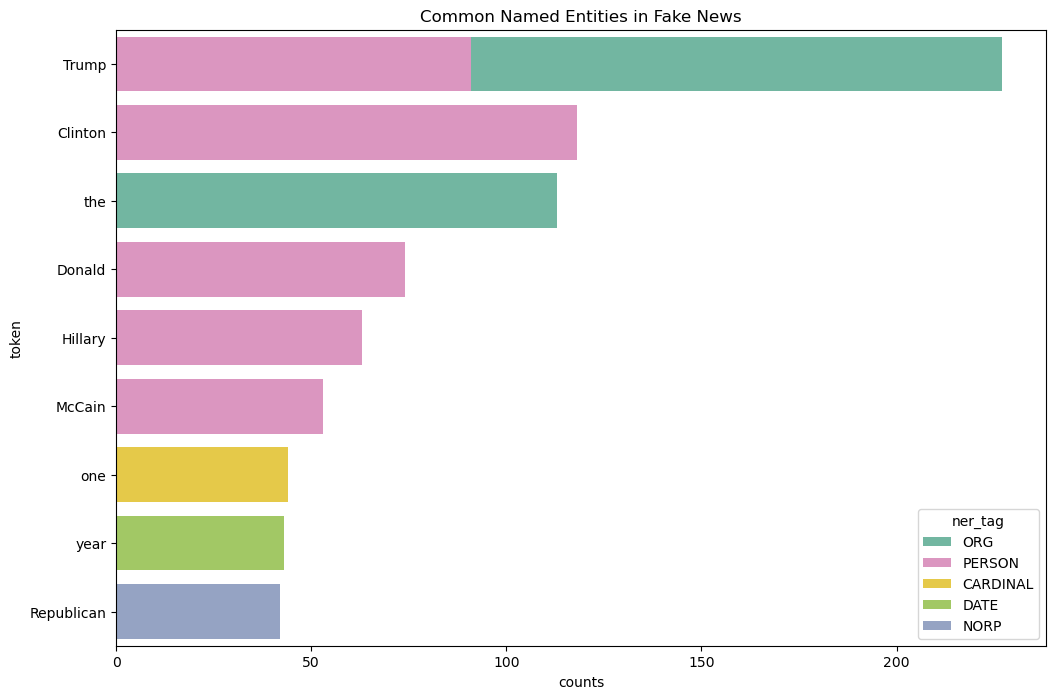

In [28]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette= ner_color_palette,
    data = fake_top_entitites[:10],
    orient = 'h',
    dodge = False
).set(title="Common Named Entities in Fake News")

[Text(0.5, 1.0, 'Common Named Entities in Factual News')]

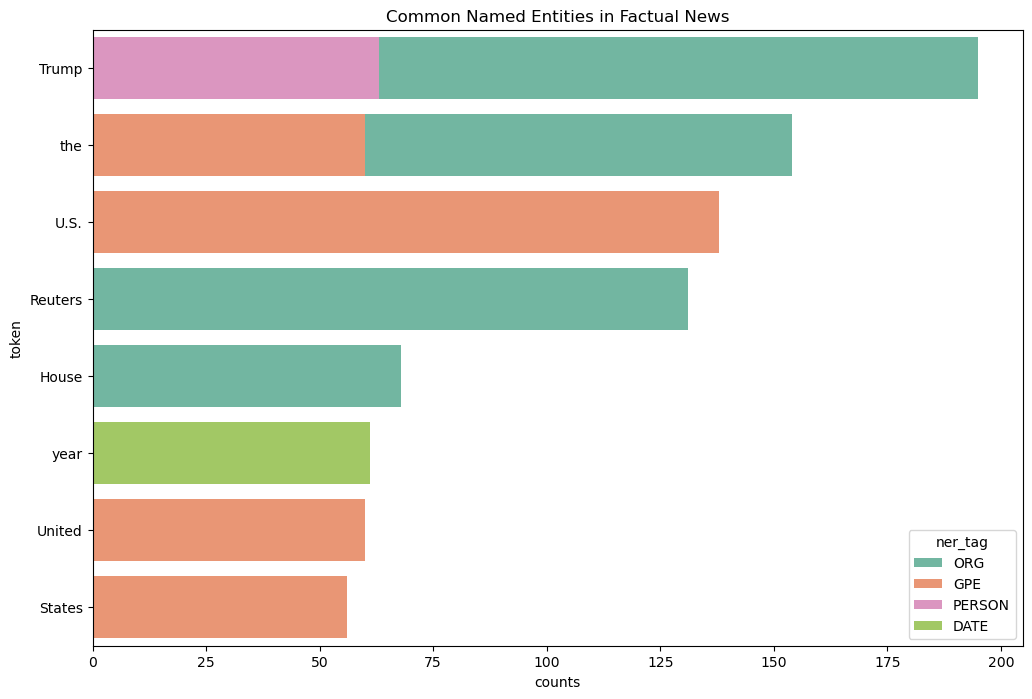

In [29]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette= ner_color_palette,
    data = fact_top_entitites[:10],
    orient = 'h',
    dodge = False
).set(title="Common Named Entities in Factual News")

###  Pre Processing

In [30]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [31]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x['text']), axis=1)

In [32]:
data['text_clean'] = data['text_clean'].str.lower()

In [33]:
data['text_clean'] = data.apply(lambda x: re.sub(r"[^\w\s]", "", x['text_clean']), axis=1)

In [34]:
en_stopwords = stopwords.words('english')

In [35]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [36]:
# Tokenizing
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [37]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [38]:
tokens_clean = sum(data['text_clean'], [])
tokens_clean[:5]

['two', 'small', 'problem', 'analogy', 'susan']

In [42]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


In [43]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])
unigrams

,index,count,token
0,"(said,)",580,said
1,"(trump,)",580,trump
2,"(u,)",277,u
3,"(state,)",275,state
4,"(president,)",259,president
5,"(would,)",226,would
6,"(one,)",160,one
7,"(clinton,)",141,clinton
8,"(year,)",139,year
9,"(republican,)",137,republican


[Text(0.5, 1.0, 'Most common Unigrams after text-preprocessing')]

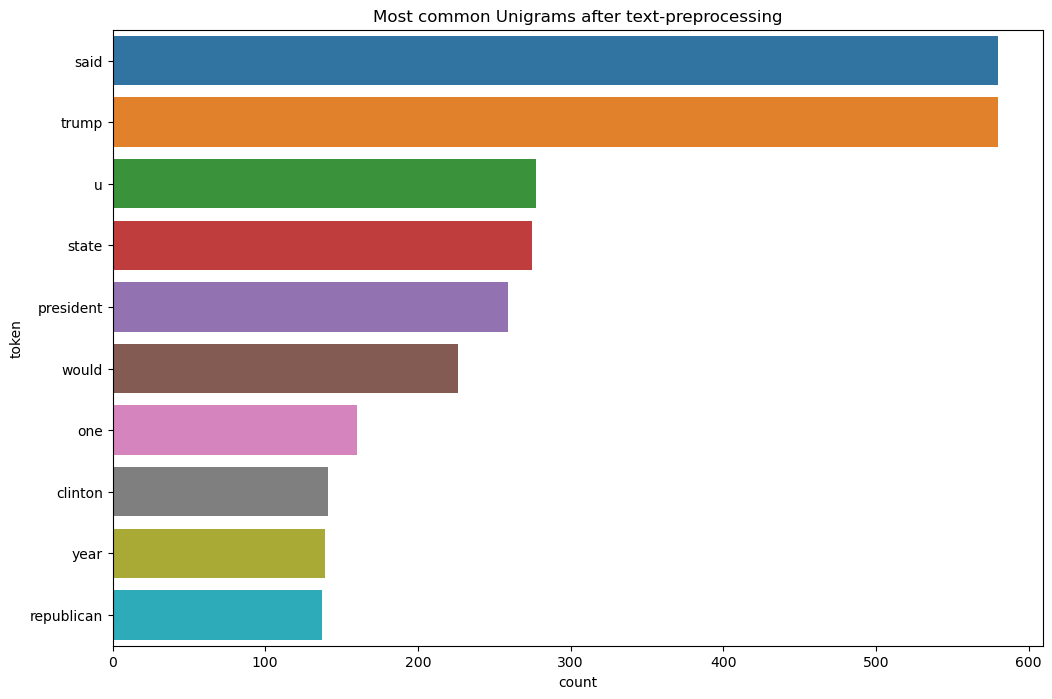

In [44]:
sns.barplot(x="count",
    y="token",
    data=unigrams,
    orient="h",
    # palette=[default_plot_color],
    hue="token",
    legend=False\
).set(title="Most common Unigrams after text-preprocessing")

In [46]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


In [47]:
bigrams['token'] = bigrams['index'].apply(lambda x: x[0])
bigrams

,index,count,token
0,"(donald, trump)",113,donald
1,"(united, state)",84,united
2,"(white, house)",74,white
3,"(president, donald)",47,president
4,"(hillary, clinton)",39,hillary
5,"(new, york)",33,new
6,"(supreme, court)",30,supreme
7,"(image, via)",29,image
8,"(official, said)",26,official
9,"(trump, administration)",26,trump


[Text(0.5, 1.0, 'Most common Unigrams after text-preprocessing')]

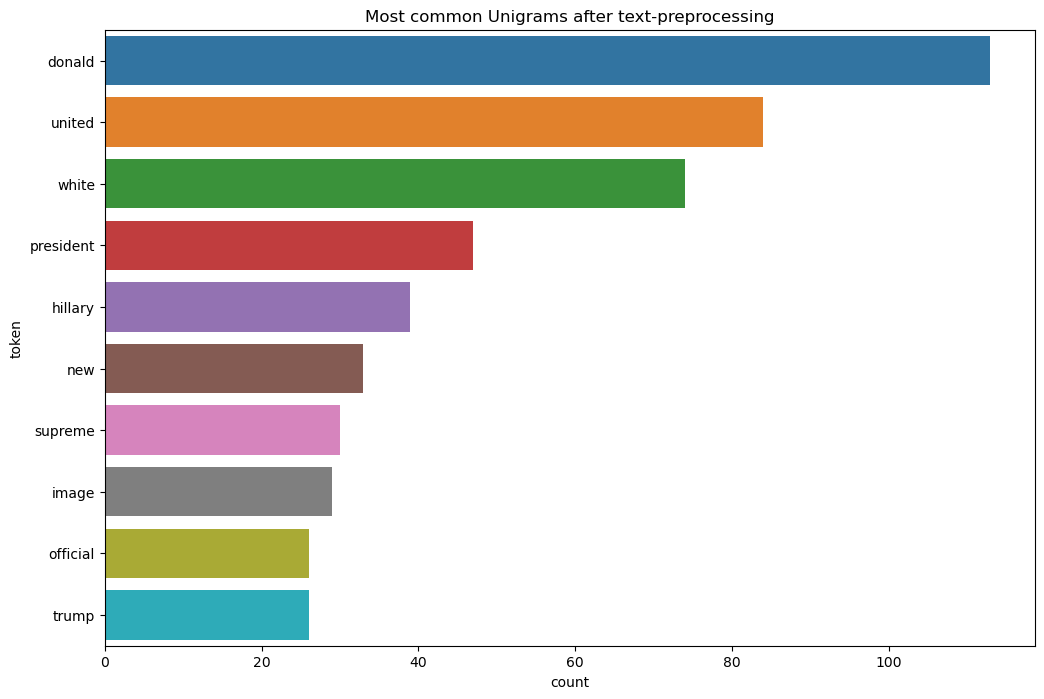

In [48]:
sns.barplot(x="count",
    y="token",
    data=bigrams,
    orient="h",
    # palette=[default_plot_color],
    hue="token",
    legend=False\
).set(title="Most common Unigrams after text-preprocessing")

### Sentiment Analysis

In [49]:
vader_sentiment = SentimentIntensityAnalyzer()

In [50]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [51]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

In [52]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [54]:
data.head() 

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: ylabel='vader_sentiment_label'>

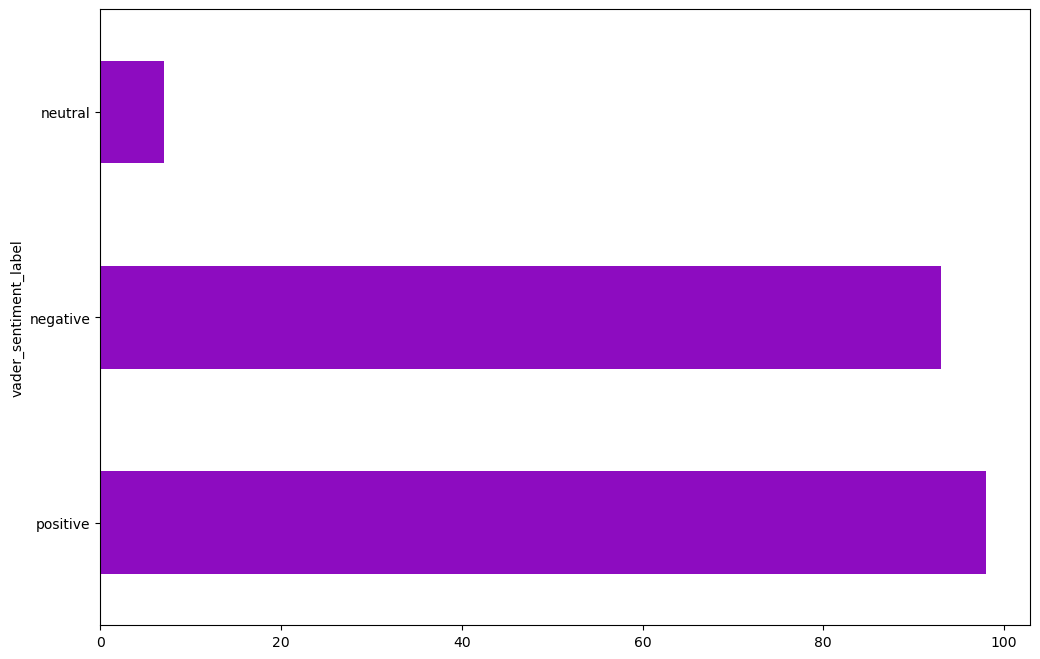

In [57]:
data['vader_sentiment_label'].value_counts().plot.barh(color=[default_plot_color])

/tmp/ipykernel_2651899/3322311995.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

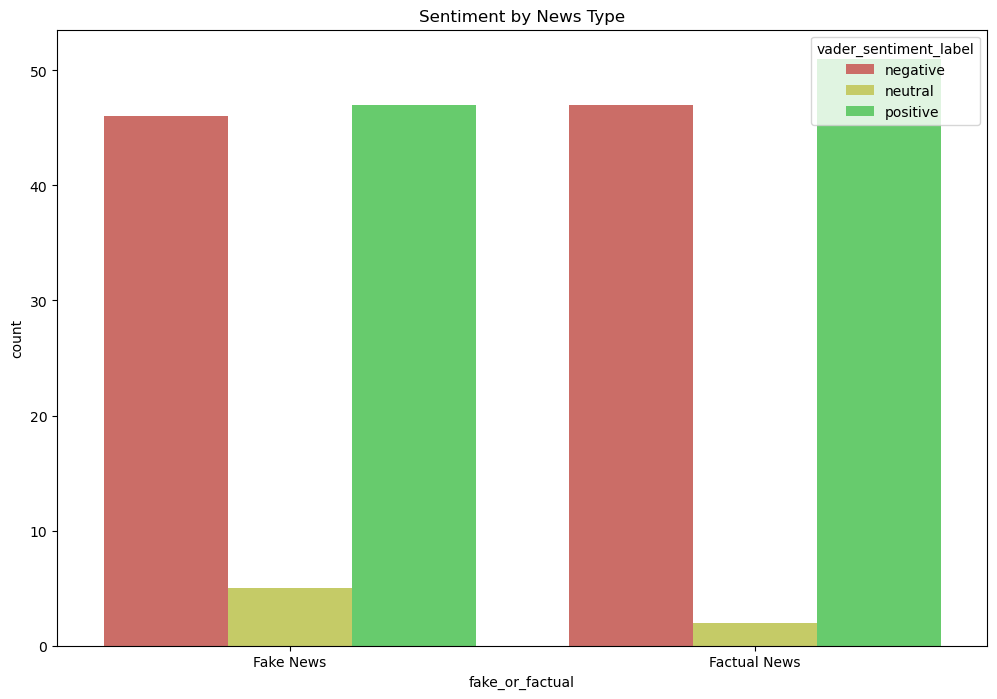

In [61]:
sns.countplot(
    x="fake_or_factual",
    hue="vader_sentiment_label",
    palette=sns.color_palette("hls"),
    data=data
).set(title='Sentiment by News Type')

### Topic Modelling

In [65]:
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)
fake_news_text

0     [two, small, problem, analogy, susan, jesus, m...
1     [buried, trump, bonkers, interview, new, york,...
2     [woman, make, 50, percent, country, grossly, u...
3     [shame, teen, vogue, maxine, water, guest, tee...
4     [former, white, house, press, secretary, obama...
                            ...                        
93    [jon, ritzheimer, infamous, hater, muslim, one...
94    [well, take, long, look, first, beastiality, m...
95    [florida, toxic, dangerous, stand, ground, gun...
96    [politico, report, almost, neckandneck, race, ...
97    [small, obscure, community, college, disallowi...
Name: text_clean, Length: 98, dtype: object

In [66]:
fake_dictionary = corpora.Dictionary(fake_news_text)

In [69]:
doc_term_fake = [fake_dictionary.doc2bow(text) for text in fake_news_text]

In [75]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics + 1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word=fake_dictionary)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=fake_dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

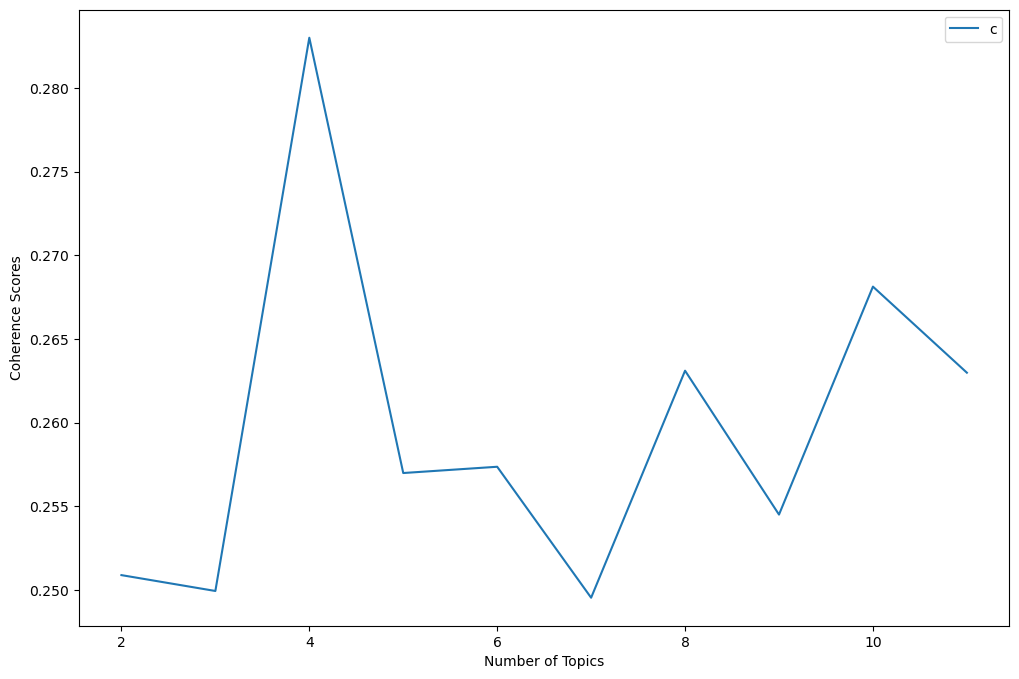

In [77]:
plt.plot(range(min_topics, max_topics + 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel('Coherence Scores')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [78]:
num_topics_lda = 4
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=fake_dictionary, num_topics=num_topics_lda)

In [79]:
lda_model.print_topics()

[(0,
  '0.015*"trump" + 0.006*"clinton" + 0.005*"said" + 0.005*"president" + 0.004*"donald" + 0.004*"one" + 0.004*"would" + 0.004*"hillary" + 0.003*"time" + 0.003*"state"'),
 (1,
  '0.008*"trump" + 0.005*"said" + 0.005*"state" + 0.005*"republican" + 0.004*"president" + 0.004*"would" + 0.004*"people" + 0.003*"u" + 0.003*"one" + 0.003*"also"'),
 (2,
  '0.011*"trump" + 0.005*"u" + 0.005*"said" + 0.004*"state" + 0.003*"time" + 0.003*"president" + 0.003*"mccain" + 0.003*"american" + 0.003*"one" + 0.003*"republican"'),
 (3,
  '0.008*"trump" + 0.005*"president" + 0.005*"clinton" + 0.004*"would" + 0.004*"woman" + 0.003*"state" + 0.003*"time" + 0.003*"people" + 0.003*"said" + 0.003*"law"')]

In [82]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [83]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics + 1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherence_model.get_coherence())

    plt.plot(range(min_topics, max_topics + 1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend(('coherence_values'), loc='best')
    plt.show()

In [85]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

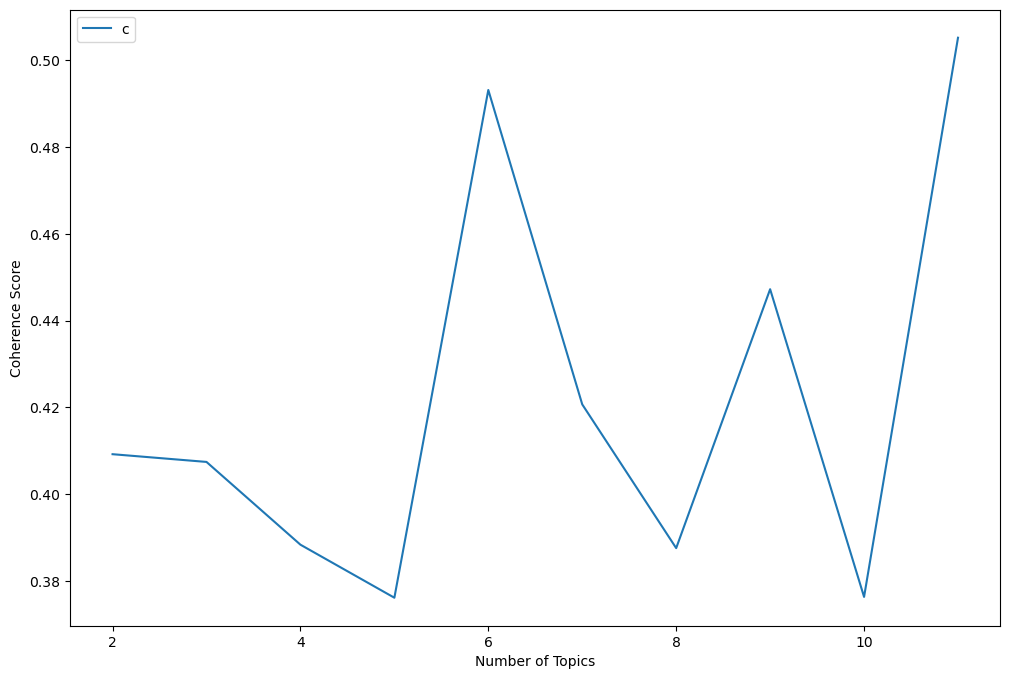

In [86]:
get_coherence_scores(corpus_tfidf_fake, fake_dictionary, fake_news_text, min_topics=2, max_topics=11)

In [87]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=fake_dictionary, num_topics=6)

In [89]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"animal" + -0.142*"tune" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '0.623*"flynn" + 0.182*"immunity" + 0.122*"nana" + 0.116*"mr" + 0.110*"30" + 0.108*"march" + 0.102*"russian" + 0.100*"source" + -0.095*"school" + 0.092*"adviser"'),
 (3,
  '-0.217*"clinton" + 0.186*"school" + 0.176*"student" + -0.141*"hillary" + 0.121*"county" + 0.121*"flynn" + -0.110*"sander" + -0.098*"debate" + -0.097*"woman" + -0.091*"nominee"'),
 (4,
  '-0.200*"email" + 0.194*"trump" + -0.168*"dnc" + 0.142*"flynn" + -0.126*"clinton" + 0.112*"cruz" + -0.111*"department" + -0.110*"rich" + -0.102*"wikileaks" + -0.099*"sander"'),
 (5,
  '-0.276*"student" + -0.160*"conference" + -0.160*"school" + -0.137*"trump" + 0.125*"mc

### Creating our own ***Classification Model***